## Computations for Chandrayaan 2 visibility from Dwingeloo

This computation was inpsired by [this tweet](https://twitter.com/df2mz/status/1163040573185544192) from Edgar Kaiser.

In [117]:
from astroquery.jplhorizons import Horizons

In [118]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, get_moon
import astropy.units as u

In [119]:
import matplotlib.pyplot as plt

In [120]:
from matplotlib import dates

In [121]:
import numpy as np

In [122]:
dwl = EarthLocation(lat="52d48m43.27", lon="6d23m46.21", height="25m")
dwl_jpl = {'lat': dwl.lat.deg, 'lon': dwl.lon.deg, 'elevation': dwl.height.to(u.m).value}

In [123]:
epochs = Time("2019-08-20T00:00") + np.linspace(0, 7, 100, endpoint=False)*u.hour

In [124]:
ephem = Horizons(id='Chandrayaan-2', location=dwl_jpl, epochs=list(epochs.jd), id_type='majorbody').ephemerides()

In [125]:
moon = get_moon(epochs, ephemeris="jpl")

I think `get_moon` gives apparent coordinates. To compare those to the JPL coordinates for Chandrayaan, we need to get its apparent RA and DEC as well.

In [126]:
chandrayaan = SkyCoord(ra=ephem['RA_app'], dec=ephem['DEC_app'])

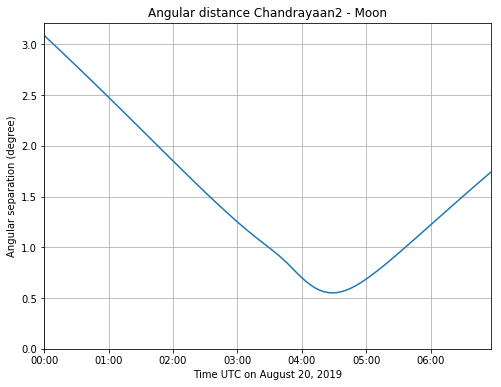

In [130]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(epochs.datetime, moon.separation(chandrayaan));
ax.set_title("Angular distance Chandrayaan2 - Moon")
ax.grid()
ax.margins(x=0)
ax.set_ylim(0, None)
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M'))
ax.set_xlabel("Time UTC on August 20, 2019")
ax.set_ylabel("Angular separation (degree)");

In [131]:
min(moon.separation(chandrayaan)).deg

0.5510780425783527